In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make('MountainCar-v0')
state = env.reset()
state

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


array([-0.45299038,  0.        ], dtype=float32)

In [3]:
import gc
import keras
from keras.models import Sequential
from keras.layers import Dense
from collections import deque
import random

In [4]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, input_dim=2, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 2,853
Trainable params: 2,853
Non-trainable params: 0
_________________________________________________________________


In [6]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
learning_rate = 0.001
gamma = 0.99
epsilon = 0.3
batch_size = 256
episodes = 200
max_steps = 200
target_model = keras.models.clone_model(model)
memory = deque(maxlen=200)
sync_freq = 30
predict_max = 500
predict_curr = 0

In [7]:
def pred(model, state):
  global predict_curr
  if predict_curr == predict_max:
    gc.collect()
    keras.backend.clear_session()
    predict_curr = 0
  predict_curr += 1
  return model.predict(state, verbose=0)

In [8]:
def train():
  state_batch, Qs_target_batch = [], []
  minibatch = random.sample(memory, batch_size)
  minibatch_iter = iter(minibatch)
  while True:
    try:
      state, action, reward, next_state, done = next(minibatch_iter)
      if done:
          y = reward
      else:
          next_action = np.argmax(pred(model,next_state)[0])
          target = reward + gamma * pred(target_model,next_state)[0][next_action]
          y = target
        
      q_values = pred(model,state)
      q_values[0][action] = y

      state_batch.append(state)
      Qs_target_batch.append(q_values)
    except StopIteration:
        break

  state_batch = np.array(state_batch).reshape(batch_size,state_size)
  Qs_target_batch = np.array(Qs_target_batch).reshape(batch_size,action_size)

  h = model.fit(state_batch, Qs_target_batch,epochs=1, verbose=0)

  loss = h.history['loss'][0]

  return loss

In [9]:
Loss = []
Rewards = []
j = 0

In [11]:
for episode in range(episodes):
  max_state = -1.0
  total_reward = 0
  t = 0

  state = env.reset()
  state = np.reshape(state, [1, state_size])

  done = False
  while not done and t < max_steps:
    j += 1

    q_values = pred(model,state)[0]

    if np.random.rand() <= epsilon:
      action = random.randrange(action_size)
    else:
      action = np.argmax(q_values[0])
      
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])

    if next_state[0][0] > max_state:
      max_state = next_state[0][0]
      reward = 1
    elif max_state >= 0.5:
      reward = 100
      print("Car reached the goal")
      done = True  
    else:
      reward = -1

    total_reward += reward

    memory.append((state, action, reward, next_state, done))

    if len(memory) > batch_size:
      loss = train()
      Loss.append(loss)

    state = next_state
    t += 1

    if j % sync_freq == 0:
      target_model.set_weights(model.get_weights())

  print(episode+1, ") Reward = ", total_reward)
  Rewards.append(total_reward)

1 ) Reward =  -164
2 ) Reward =  -176
3 ) Reward =  -164
4 ) Reward =  -198
5 ) Reward =  -176
6 ) Reward =  -180
7 ) Reward =  -192
8 ) Reward =  -174
9 ) Reward =  -186
10 ) Reward =  -180
11 ) Reward =  -154
12 ) Reward =  -170
13 ) Reward =  -178
14 ) Reward =  -198
15 ) Reward =  -178
16 ) Reward =  -178
17 ) Reward =  -198
18 ) Reward =  -188
19 ) Reward =  -178
20 ) Reward =  -198
21 ) Reward =  -148
22 ) Reward =  -192
23 ) Reward =  -170
24 ) Reward =  -170
25 ) Reward =  -198
26 ) Reward =  -164
27 ) Reward =  -158
28 ) Reward =  -148
29 ) Reward =  -178
30 ) Reward =  -156
31 ) Reward =  -176
32 ) Reward =  -198
33 ) Reward =  -184
34 ) Reward =  -198
35 ) Reward =  -186
36 ) Reward =  -176
37 ) Reward =  -176
38 ) Reward =  -170
39 ) Reward =  -198
40 ) Reward =  -170
41 ) Reward =  -136
42 ) Reward =  -196
43 ) Reward =  -166
44 ) Reward =  -176
45 ) Reward =  -172
46 ) Reward =  -162
47 ) Reward =  -158
48 ) Reward =  -156
49 ) Reward =  -180
50 ) Reward =  -198
51 ) Rewa

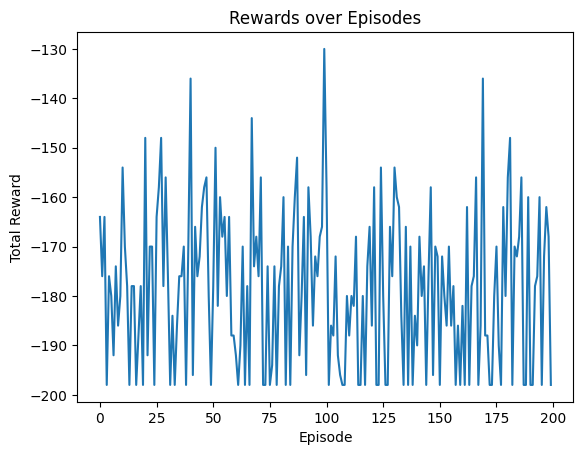

In [12]:
plt.plot(Rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()